## Aufgabe 1: {-}

Implementieren Sie ein word2vec-Modell mit $N=2000$ Eingabegröße und einem latenten Raum der Dimension $K=200$.

Implementieren Sie Training mit dem skip-gram Verfahren.

Nutzen Sie `torch.nn.Embedding` (nicht Gensim).

Als Inspiration darf

~~https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html~~

https://web.archive.org/web/20240303095409/https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html

dienen, und mit Inspiration ist gemeint, dass Copy&Paste erlaubt ist, wenn Sie wissen, was Sie da tun *und das entsprechend kennzeichnen*.

Hier haben wir uns erheblich inspirieren lassen, d.h. copy&paste mit anschließenden kleinen Änderungen.

In [1]:
NUM_WORKERS = 12

In [2]:
import torch
import torch.nn as nn

class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_embeddings = nn.Linear(embedding_dim, vocab_size, bias=False)
        nn.init.uniform_(self.in_embeddings.weight, -0.5, 0.5)

    def forward(self, words):
        latents = self.in_embeddings(words)
        logits = self.out_embeddings(latents)
        return logits, latents

In [3]:
import nltk
assert nltk.download('stopwords', quiet=True), "Without stopwords, I will stop."

In [4]:
import datasets
import re
from nltk.corpus import stopwords
from collections import Counter

def split_tokens(row, key='sms'):
    row['all_tokens'] = re.split(r" +", re.sub(r"[^a-z ]", "", row[key].lower()))
    return row

def remove_stopwords(row, stop_words):
    row['relevant_tokens'] = [word for word in row['all_tokens']
                              if (word not in stop_words) and (word is not None)]
    return row

def getTok2Id(id2tok):
    return {token: index for index, token in enumerate(id2tok)}

def get_vocab_from_dataset(data, min_frequency=5):
    # the following flattens a nested list and counts frequency:
    token_counts = Counter([i for s in data for i in s])
    frequent_counts = {t:count for t, count in token_counts.items() if count > min_frequency} # Filtering
    id2tok = [k for k, _ in sorted(frequent_counts.items(), key=lambda item: item[1])] # Sorting
    return id2tok
    
def remove_rare_tokens(row, vocab):
    row['tokens'] = [t for t in row['relevant_tokens'] if t in vocab]
    return row
    
def windowizer(row, tok2id, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window pairs.
    """
    doc = row['tokens']
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i + offset for offset in range(-wsize, wsize+1, 1)
                  if 0 <= i+offset < len(doc) and offset != 0]
        out.extend((target, tok2id[doc[w]]) for w in window)
    row['moving_window'] = out
    return row

def get_dataset_for_word2vec(name, key, num_workers=NUM_WORKERS, use_custom_word_list=False):
    dataset = datasets.load_dataset(name)
    print(f"Loading like this: {dataset['train'][key][0]}")
    dataset = dataset.map(lambda row: split_tokens(row, key=key), num_proc=num_workers)
    print(f"Tokenized like this: {' '.join(dataset['train']['all_tokens'][0])}")
    stop_words = set(stopwords.words('english'))
    dataset = dataset.map(lambda row: remove_stopwords(row, stop_words), num_proc=num_workers)
    print(f"Without stopwords: {' '.join(dataset['train']['relevant_tokens'][0])}")
    if not use_custom_word_list:
        id2tok = get_vocab_from_dataset(dataset['train']['relevant_tokens'])
    elif type(use_custom_word_list)==list:
        print("obtaining the SMS dataset with a custom wordlist...")
        id2tok = use_custom_word_list
        #XXX think about it, is that the only thing that needs to change? does it fly?
    else:
        raise RuntimeError(f"custom word list {use_custom_word_list} doesn't make sense, need bool or list.")
    dataset = dataset.map(lambda row: remove_rare_tokens(row, id2tok), num_proc=num_workers)
    print(f"Removed rare tokens: {' '.join(dataset['train']['tokens'][0])}")
    dataset = dataset.map(lambda row: windowizer(row, getTok2Id(id2tok)), num_proc=num_workers)
    return dataset, id2tok

def get_sms_dataset(num_workers=NUM_WORKERS, use_custom_word_list=False):
    return get_dataset_for_word2vec('sms_spam', 'sms', num_workers, use_custom_word_list=use_custom_word_list)

In [5]:
from torch.utils.data import Dataset

class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def train_word2vec(model, dataloader, optimizer, loss_fn, device, epochs=5):
    running_loss = []

    for epoch in range(epochs):
        epoch_loss = 0
        for center, context in dataloader['train']:
            center, context = center.to(device), context.to(device)
            optimizer.zero_grad()
            logits, _ = model(context)
            loss = loss_fn(logits, center)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss /= len(dataloader['train'])
        running_loss.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return running_loss

## Aufgabe 2: {-}

Trainieren Sie ihr word2vec-Modell auf dem SMS-Spam/Ham-Datensatz.

Zeigen Sie den Verlauf der Loss-Werte über die Trainingsepochen für wenigstens 5 Epochen.

Visualisieren Sie die latenten Vektoren.

Dazu dürfen Sie auch Code recyceln aus dem vorigen Übungsblatt.

In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim

torch.manual_seed(39)

def train_word2vec_with_data(dataset, id2tok, embedding_dim=200,
                             lr=3e-4, batch_size=64, n_loader_procs=NUM_WORKERS,
                             epochs=12):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SkipGramModel(vocab_size=len(id2tok), embedding_dim=embedding_dim)
    model.to(device)
    assert 'train' in dataset, "Something went quite wrong here... I need a break."
    dataloader = {}
    dataloader['train'] = DataLoader(Word2VecDataset(dataset['train'], vocab_size=len(id2tok)),
                                     batch_size=batch_size,
                                     #shuffle=True,
                                     num_workers=n_loader_procs)
    # Training
    losses = train_word2vec(model,
                            dataloader,
                            torch.optim.Adam(model.parameters(), lr=lr),
                            nn.CrossEntropyLoss(),
                            device,
                            epochs=epochs)
    return model, losses

In [8]:
dataset, id2tok = get_sms_dataset()
model, losses = train_word2vec_with_data(dataset, id2tok)

Loading like this: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Tokenized like this: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Without stopwords: go jurong point crazy available bugis n great world la e buffet cine got amore wat
Removed rare tokens: go point crazy available bugis n great world la e cine got wat
Epoch 1/12, Loss: 7.0636
Epoch 2/12, Loss: 6.4809
Epoch 3/12, Loss: 6.1663
Epoch 4/12, Loss: 5.9691
Epoch 5/12, Loss: 5.8219
Epoch 6/12, Loss: 5.7054
Epoch 7/12, Loss: 5.6101
Epoch 8/12, Loss: 5.5305
Epoch 9/12, Loss: 5.4627
Epoch 10/12, Loss: 5.4038
Epoch 11/12, Loss: 5.3518
Epoch 12/12, Loss: 5.3053


In [9]:
def visualize_word2vec_latents(model, id2tok, label_first=30):
    model.eval()
    all_latent_vectors = model.in_embeddings.weight.detach().cpu().numpy()
    pca = PCA(n_components=2)
    reduced_latent_vectors = pca.fit_transform(all_latent_vectors)
    plt.figure(figsize=(10,10))
    plt.scatter(reduced_latent_vectors[:, 0], reduced_latent_vectors[:, 1], alpha=0.2)
    for (x, y), (index, word) in zip(reduced_latent_vectors[:label_first],
                                     enumerate(id2tok[:label_first])):
        rankingalpha = 0.2 + 0.8*(1 - index/label_first)
        plt.scatter(x, y, marker='o', color='red', alpha=rankingalpha)
        plt.text(x + 0.02, y + 0.02, word, fontsize=9, alpha=rankingalpha)
    plt.title('Latent Vector Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def visualize_loss_curve(losses):
    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Word2Vec Training Loss')
    plt.show()

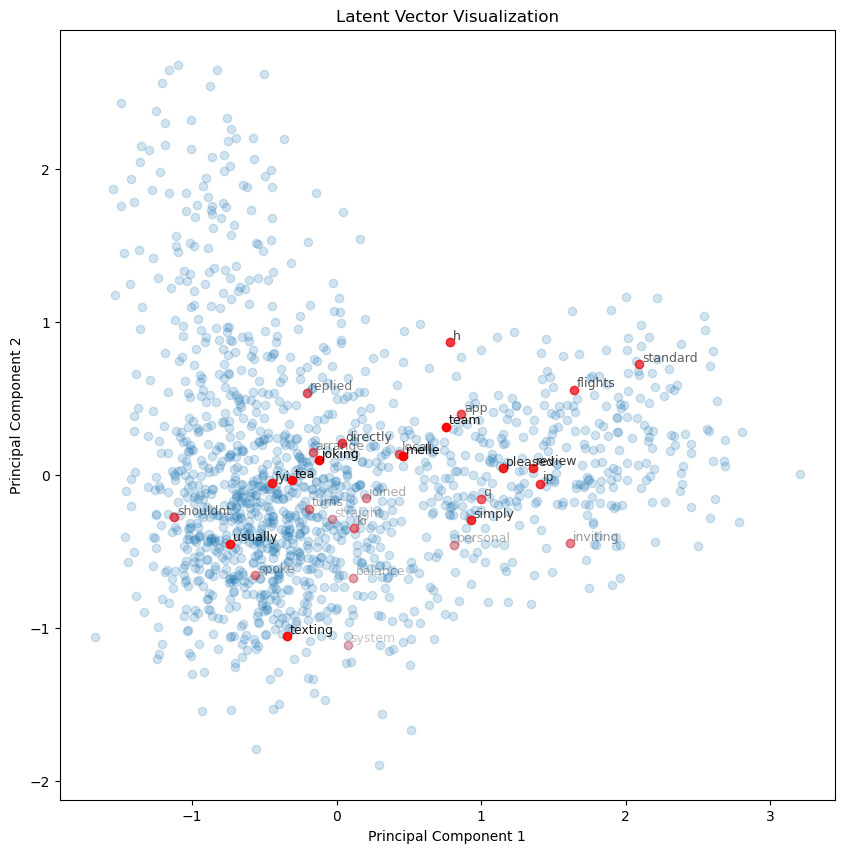

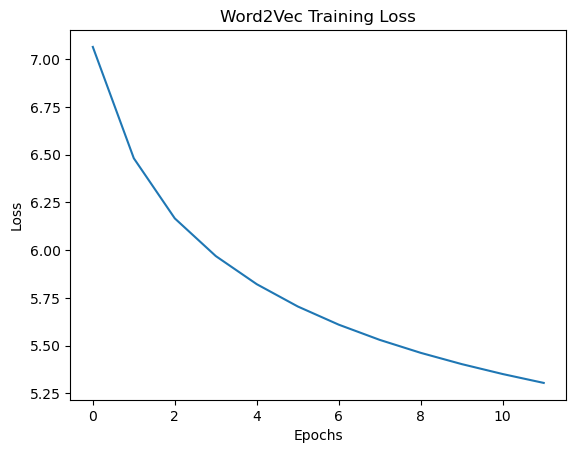

In [10]:
visualize_word2vec_latents(model, id2tok)
visualize_loss_curve(losses)

## Aufgabe 3: {-}

  Laden Sie Gewichte für ein word2vec-Modell mit der gensim-Bibliothek herunter (z.B. die `google-news-300`-Gewichte) und nutzen diese zur Initialiserung Ihres eigenen word2vec-Modells.

  Achtung: die Liste der betrachteten Token/Wörter ist dabei eine andere als zuvor!

In [11]:
import gensim.downloader as gensim_api

def initialize_word2vec_with_gensim_weights(gensim_model, vocab_size_cap=10000, freeze=False):
    """creates a SkipGramModel with embedding_size like the gensim_model"""
    # Load pre-trained Gensim Word2Vec model
    word_vectors = gensim_model.vectors
    vocab_size, embedding_size = word_vectors.shape
    if(vocab_size > vocab_size_cap):
        vocab_size = vocab_size_cap
        word_vectors = word_vectors[:vocab_size_cap]
    model = SkipGramModel(vocab_size, embedding_size)
    model.in_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(word_vectors),
                                                       freeze=freeze)
    return model

gensim_model = gensim_api.load("word2vec-google-news-300")
gensim_model.sort_by_descending_frequency()
pretrained_model = initialize_word2vec_with_gensim_weights(gensim_model)
print(pretrained_model)

SkipGramModel(
  (in_embeddings): Embedding(10000, 300)
  (out_embeddings): Linear(in_features=300, out_features=10000, bias=False)
)


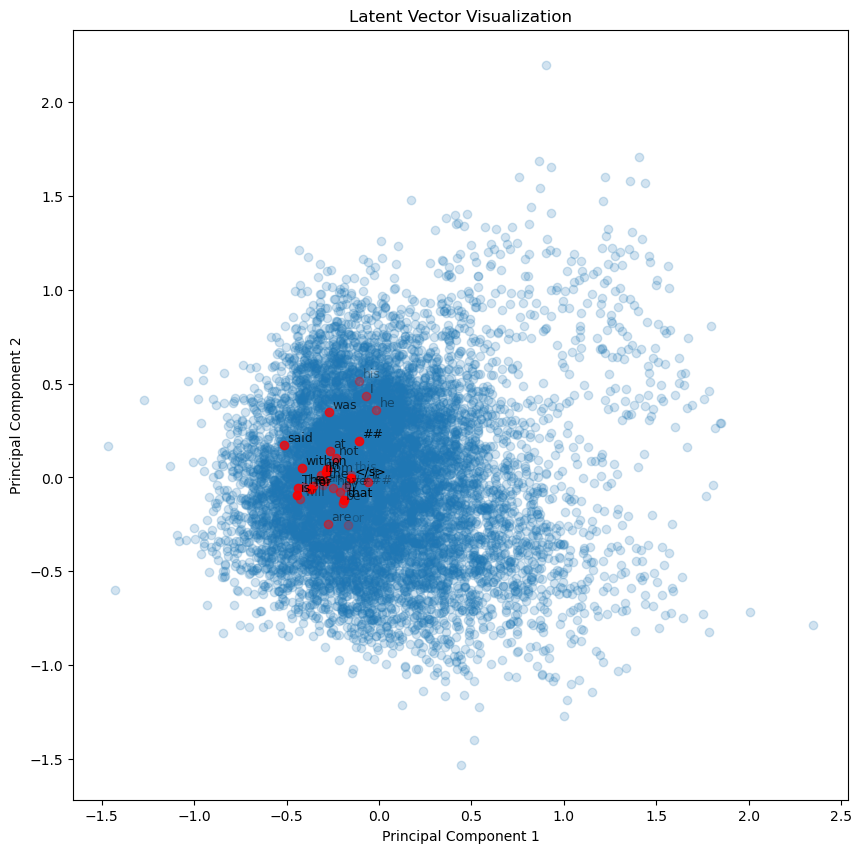

In [12]:
word_list = gensim_model.index_to_key[:10000]
visualize_word2vec_latents(pretrained_model, word_list)

Trainieren Sie Ihr vorinitialisiertes word2vec-Modell weiter auf dem SMS-Spam/Ham-Datensatz.
Zeigen Sie den Verlauf der Loss-Werte über die Trainingsepochen für wenigstens 5 Epochen.

Das Vorgehen nennt sich 'Pretraining+Finetuning'. Beschreiben Sie, was Sie denken, warum Sie den Effekt sehen, den Sie sehen.

Wir entscheiden uns für das folgende Vorgehen:
Die Wortliste vom vortrainierten Modell wird verwendet; dazu muss der SMS-Datensatz anders eingelesen werden.

In [13]:
# make loading datasets faster on multicore systems:
torch.set_num_threads(NUM_WORKERS)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model.to(device)

dataset, id2tok = get_sms_dataset(use_custom_word_list=word_list)
assert id2tok == word_list, "Dataset vocabulary and pre-trained vocabulary do not align!"
assert set(dataset['train']['tokens'][0]).issubset(set(word_list)), "Dataset tokens not in word list!"

Loading like this: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Tokenized like this: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
Without stopwords: go jurong point crazy available bugis n great world la e buffet cine got amore wat
obtaining the SMS dataset with a custom wordlist...
Removed rare tokens: go point crazy available n great world e got


In [15]:
assert 'train' in dataset, "Something went quite wrong here... I need a break."
dataloader = {}
dataloader['train'] = DataLoader(Word2VecDataset(dataset['train'], vocab_size=len(id2tok)),
                                 batch_size=256,
                                 #shuffle=True,
                                 num_workers=NUM_WORKERS)
losses = train_word2vec(pretrained_model,
                        dataloader,
                        torch.optim.Adam(pretrained_model.parameters(), lr=3e-4),
                        nn.CrossEntropyLoss(),
                        device,
                        epochs=12)

Epoch 1/12, Loss: 8.3434
Epoch 2/12, Loss: 7.0243
Epoch 3/12, Loss: 6.7176
Epoch 4/12, Loss: 6.5690
Epoch 5/12, Loss: 6.4504
Epoch 6/12, Loss: 6.3435
Epoch 7/12, Loss: 6.2436
Epoch 8/12, Loss: 6.1487
Epoch 9/12, Loss: 6.0577
Epoch 10/12, Loss: 5.9702
Epoch 11/12, Loss: 5.8862
Epoch 12/12, Loss: 5.8059


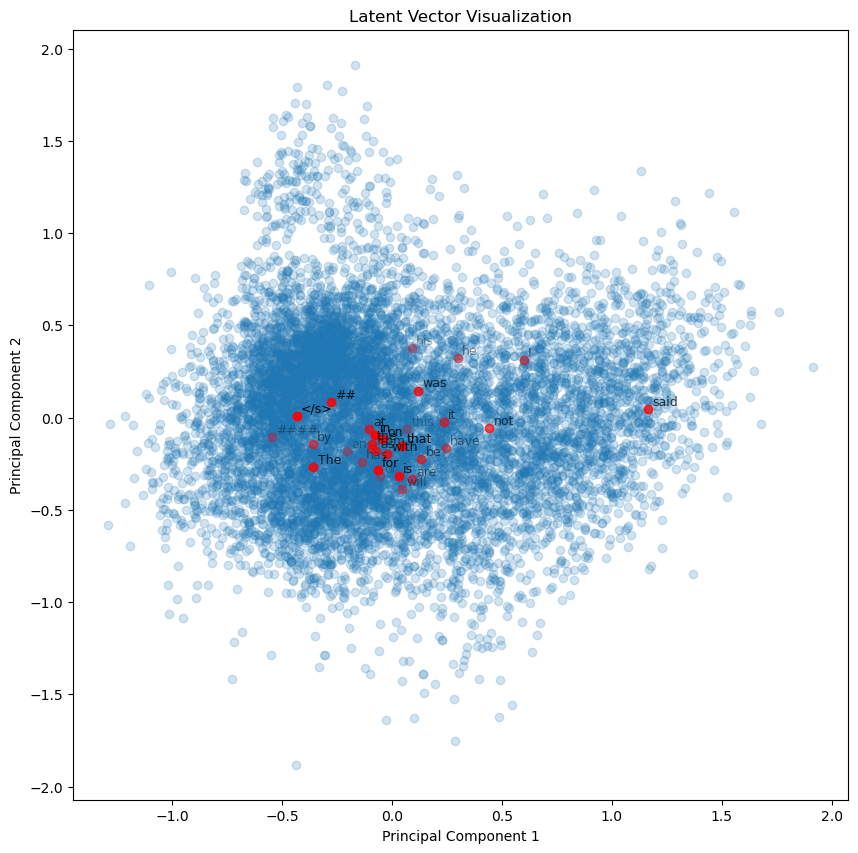

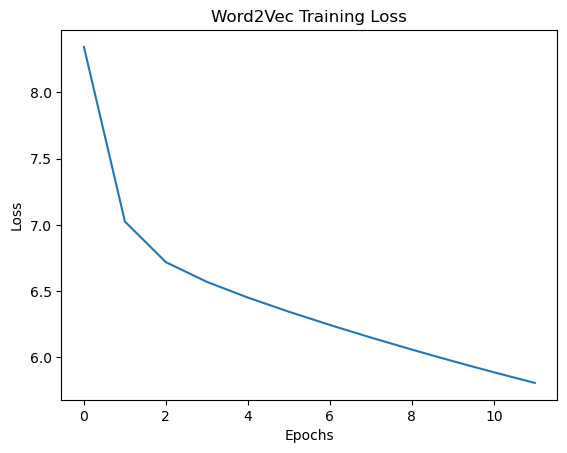

In [16]:
visualize_word2vec_latents(pretrained_model, word_list)
visualize_loss_curve(losses)

Wir beobachten eine große Änderung in den latenten Vektoren vom Pretraining zum Training. Der Training Loss geht in 12 Epochen nicht ganz so tief herunter, weil die Wortliste ungünstig ist für den Datensatz. Wenn der Pretrainings-Datensatz (hier konkret vor Allem die Liste häufiger Worte) näher dran ist am Trainings-Datensatz ist üblicherweise Pretraining sehr nützlich. Man beachte, dass im Vergleich der Loss-Kurven sogar die Variante mit Pretraining einen größeren latenten Raum hat, also eigentlich niedrigere Loss-Werte erreichen könnte.